<a href="https://colab.research.google.com/github/Ke-erah/Cousera_Capstone/blob/master/US_Schools_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read in the data

In [0]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [0]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [0]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [0]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [0]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [0]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [0]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [0]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [0]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [0]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [0]:
import matplotlib.pyplot as plt

In [0]:
survey_fields

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

In [0]:
correlations = combined.corr()
correlations

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
SAT Critical Reading Avg. Score,1.000000,0.929221,0.982826,0.986820,0.490283,0.483479,0.441813,0.289710,0.035699,0.357418,...,NaN,NaN,-0.064120,0.367945,0.111556,NaN,NaN,NaN,-0.119993,-0.126479
SAT Math Avg. Score,0.929221,1.000000,0.931385,0.972643,0.545646,0.533239,0.469456,0.379012,0.078078,0.444985,...,NaN,NaN,-0.033971,0.460646,0.134403,NaN,NaN,NaN,-0.134572,-0.120055
SAT Writing Avg. Score,0.982826,0.931385,1.000000,0.987771,0.501648,0.495321,0.451790,0.282701,0.009161,0.353928,...,NaN,NaN,-0.093174,0.366308,0.096834,NaN,NaN,NaN,-0.100551,-0.143850
sat_score,0.986820,0.972643,0.987771,1.000000,0.523140,0.514333,0.463245,0.325144,0.042948,0.394626,...,NaN,NaN,-0.063977,0.407827,0.117012,NaN,NaN,NaN,-0.121029,-0.132222
AP Test Takers,0.490283,0.545646,0.501648,0.523140,1.000000,0.992192,0.901513,0.602802,0.091956,0.699954,...,NaN,NaN,0.066540,0.677453,0.178590,NaN,NaN,NaN,-0.104464,-0.053121
Total Exams Taken,0.483479,0.533239,0.495321,0.514333,0.992192,1.000000,0.930634,0.558005,0.073661,0.662042,...,NaN,NaN,0.055484,0.640075,0.143048,NaN,NaN,NaN,-0.092747,-0.060357
Number of Exams with scores 3 4 or 5,0.441813,0.469456,0.451790,0.463245,0.901513,0.930634,1.000000,0.383447,0.009065,0.503843,...,NaN,NaN,0.034659,0.461334,-0.002438,NaN,NaN,NaN,-0.049501,-0.036566
Total Cohort,0.289710,0.379012,0.282701,0.325144,0.602802,0.558005,0.383447,1.000000,0.268492,0.918767,...,NaN,NaN,0.159297,0.919198,0.642994,NaN,NaN,NaN,-0.173088,-0.003523
CSD,0.035699,0.078078,0.009161,0.042948,0.091956,0.073661,0.009065,0.268492,1.000000,0.243370,...,NaN,NaN,0.812558,0.278267,0.287908,NaN,NaN,NaN,-0.530901,0.318252
NUMBER OF STUDENTS / SEATS FILLED,0.357418,0.444985,0.353928,0.394626,0.699954,0.662042,0.503843,0.918767,0.243370,1.000000,...,NaN,NaN,0.148213,0.947036,0.619696,NaN,NaN,NaN,-0.169959,-0.036394


In [0]:
survey_data = correlations['sat_score'][survey_fields]
survey_data

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64

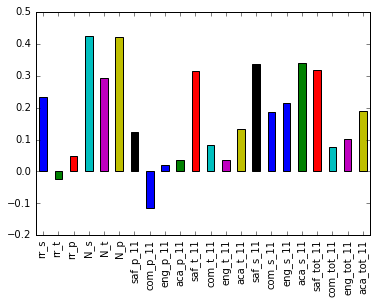

In [0]:
%matplotlib inline
survey_data.plot.bar()

High correlations can be observed between N_s, N_t, N_p and sat_score. But cconsidering that these columns are correlated with total_enrollment, it makes sense that they would be high.

The student response rate(rr_s) or the percentage of students that completed the survey, correlates with sat_score. Thiscan be explained thus: students who are more likely to fill out surveys are more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

# **Exploring Safety and SAT Scores**

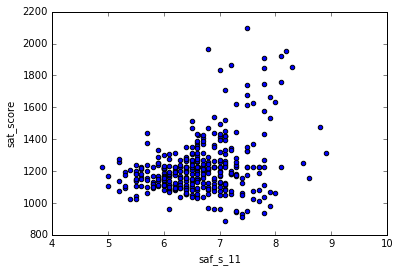

In [0]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

A weak positive correlation can be seen between safety score and SAT sores. 
There are some schools with high SAT scores and high safety scores. There are also some with low safety scores and low SAT scores. 

There is no school with a safety score lower than 6.5 that has an average SAT score higher than 1500.

# **Plotting Safety**

In [0]:
safety_by_district = combined.groupby('school_dist').agg(np.mean)
safety_by_district.reset_index(inplace=True)
safety_by_district.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


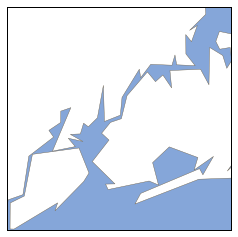

In [0]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

In [0]:
latitudes=safety_by_district['lat'].tolist()
longitudes = safety_by_district['lon'].tolist()

RuntimeError: Can not put single artist in more than one figure

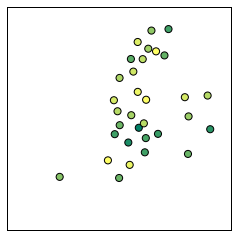

In [0]:
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c = safety_by_district['saf_s_11'], cmap='summer')
plt.show()

It looks like Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas Brooklyn has low safety scores.

# **Exploring Race and SAT Scores**

In [0]:
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
races_df = combined.corr()
races_df = races_df['sat_score'][races]
races_df

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64

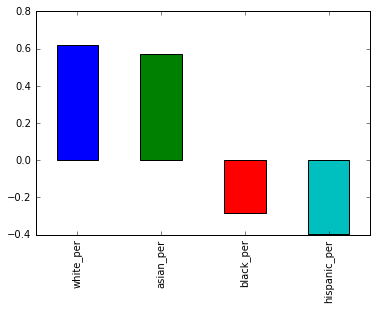

In [0]:
races_df.plot.bar()

Observation: a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score.

# **Exploring low SAT & High Hispanic Students**

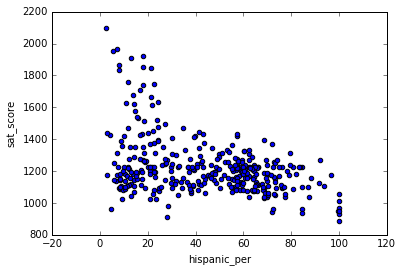

In [0]:
combined.plot.scatter(y='sat_score',x='hispanic_per')

The plot shows a fairly strong negative correlation between percentage of hispanic students and the SAT scores.

In [0]:
high_hispanic_schools = combined[combined['hispanic_per'] > 95]['SCHOOL NAME']
high_hispanic_schools

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appear to be targeted mostly at immigrants and have a low percentage of English Language Learners. This could explain the low SAT scores

In [0]:
low_hispanic_high_score = combined[(combined['hispanic_per'] < 10) &
                                   (combined['sat_score'] > 1800)]['SCHOOL NAME']
low_hispanic_high_score

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools are all top rated schools that admit students with high scores on the SHSAT(Specialized High School Admissions Test). 

They all run college-preparatory curriculums/college-style system of majors.

These high standards may explain the reason for the high SAT scores though it does not explain the low hispanic population.

# **Exploring Gender and SAT Scores**

In [0]:
genders = ['male_per', 'female_per']
gender_prop = combined.corr()['sat_score'][genders]
gender_prop

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64

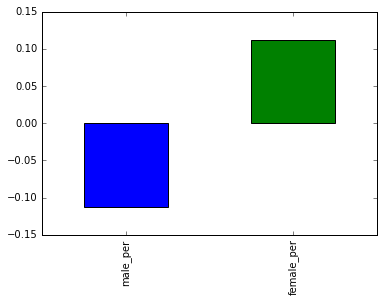

In [0]:
gender_prop.plot.bar()

There appears to be a weak negative correlation between the male gender percentage and test scores. The reverse is the case with female gender percentage where a weak positive correlation can be seen

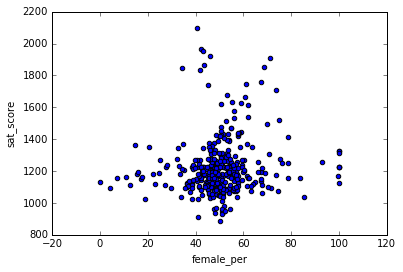

In [0]:
#Female_per vs sat_score
combined.plot.scatter(x='female_per', y='sat_score')

There doesn't appear to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [0]:
high_female_schools = combined[(combined['sat_score']>1700)
                               & (combined['female_per'] > 60)]['SCHOOL NAME']
high_female_schools

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Schools with a high percentage of female students and SAT scores have very competitive admission processes. Hence only top students attend the schools. These schools also have a specialization in arts.

# **Explorin AP Scores vs. SAT Scores**

In [0]:
combined['ap_per']= combined['AP Test Takers '] / combined['total_enrollment']

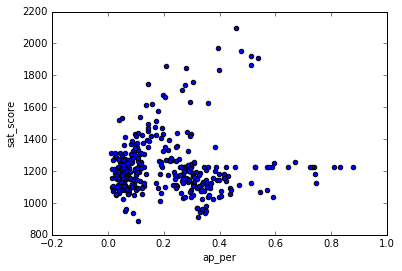

In [0]:
combined.plot.scatter(x='ap_per', y='sat_score')

There does not appear to be a strong correlation between percentage of AP test takers and the SAT scores. However, there appears to be some schools with high percentage of AP takers(greater than 50%) and hig SAT scores 

# **Exploring Class size vs. SAT Scores**

In [0]:
data['class_size'].head(1)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN


In [0]:
class_score_corr = combined.corr()['sat_score']['AVERAGE CLASS SIZE']
class_score_corr

0.3810143308095523

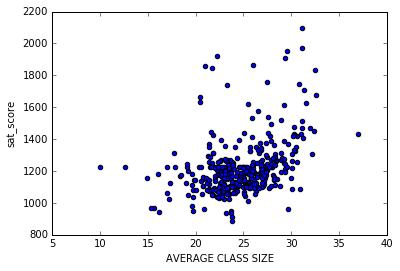

In [0]:
combined.plot.scatter(x='AVERAGE CLASS SIZE', y='sat_score')

There appears to be a weak positive correlation between average class size and SAT scores. 